# Pokemon Go screenshots classifier

In [4]:
import cv2
import os
import numpy as np
import random as rd
import matplotlib.pyplot as plt

from datetime import datetime
from shutil import copy
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from sklearn import cluster
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from tqdm import tqdm
from os.path import join

# here is my personal toy function for telling me job is done
import winsound
frequency = 1500 
duration = 200
def done():
    print("Done !")
    winsound.Beep(frequency, duration)
    pass

## 0. My data

I really have a lot of pokemon go screenshots. I've been playing a lot for last months.

In [6]:
# Resize images once for all
path = r'D:\Images\pokemon_go'
filenames = os.listdir(path)
n = len(filenames)
for filename in tqdm(filenames):
    if os.path.isfile(join(path+'_32',filename)):
        # this image has already been resized and saved
        continue
    # I have to resize this image
    img = imread(join(path,filename))
    img = resize(
        img, 
        (32,32), 
        mode='constant',
        anti_aliasing=False
    )
    imsave(join(path+'_32',filename),img)
done()

100%|████████████████████████████████████| 1423/1423 [00:00<00:00, 8628.41it/s]


Done !


In [7]:
path = r'D:\Images\pokemon_go_32'
filenames = os.listdir(path)
n = len(filenames)
print("{} screenshots of pokemon go found.".format(n))

1423 screenshots of pokemon go found.


Here is a graph of the number of screenshots taken each month.

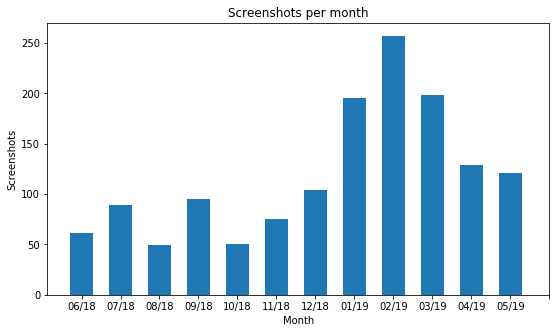

In [22]:
dates = []
months = ['06/18','07/18','08/18','09/18','10/18',
          '11/18','12/18','01/19','02/19','03/19',
          '04/19','05/19']
for s in filenames:
    date_str = s[11:19]
    date = datetime.strptime(date_str, '%Y%m%d')
    dates.append(date)
to_timestamp = np.vectorize(lambda x: x.timestamp())
time_stamps = to_timestamp(dates)
_, edges = np.histogram(time_stamps, bins=len(months))
plt.figure(figsize=(9,5))
plt.hist(time_stamps,bins=len(months), rwidth=0.6,align='left')
plt.ylabel("Screenshots")
plt.xlabel("Month")
plt.title("Screenshots per month")
plt.xticks(edges, months)
plt.show()

## 1.  Unsupervised clustering

In order to do classification on these images, we need features.
Either you consider each pixel is a feature and you can feed it to a classifier. That's very common practice with neural networks. Either you design your own features.
As a first test, I'll just try to put my images in low resolution and feed my classifier with gray-level pixels.

In [25]:
X = []
for i in range(n):
    filename = filenames[i]
    img = imread(join(path,filename))
    X.append(img)
X = np.array(X)
X = X.reshape((-1,32*32*3))
X.shape

(1423, 3072)

Now I'm trying some unsupervised clustering. There are a few things I need to figure out.

First, how many clusters do I want ? I have identified a list of use case of in-game screenshots :

I'll give them some pythonish name.

-- eggs --
* egg_will_hatch : An egg is about to hatch (Text : 'Oh ?')
* egg_opening : Hatching is starting (Golden background)
 
-- chill --
* pokemon_list : Pokemon bag view
* pokemon_detail : detail about one pokemon
* field_research : Field research list
* avatar : avatar on welcoming screen
* buddy : focus on our buddy
* level_up : level up announcement
 
-- gyms --
* raid_boss : Raid boss welcoming screen
* gym_fight : Fighting in a raid
* gym_lobby : lobbying in a raid
* gym_team : defending team on a gym
* gym_zoom : one defending pokemon with its trainer

-- catching --
* catch : pokemon catching
* new_pokemon : added to pokedex
* ar_catch : augmented reality catching
 
-- map --
* map : walking
* nearby : nearby pokemon
 
-- evolutions --
* evolution_zoom : evolution starting or ending
* evolution_light : evolution light during the animation

This list sum up to 19 use case ! A perfect unsupervised algorithm could do this kind of clustering.

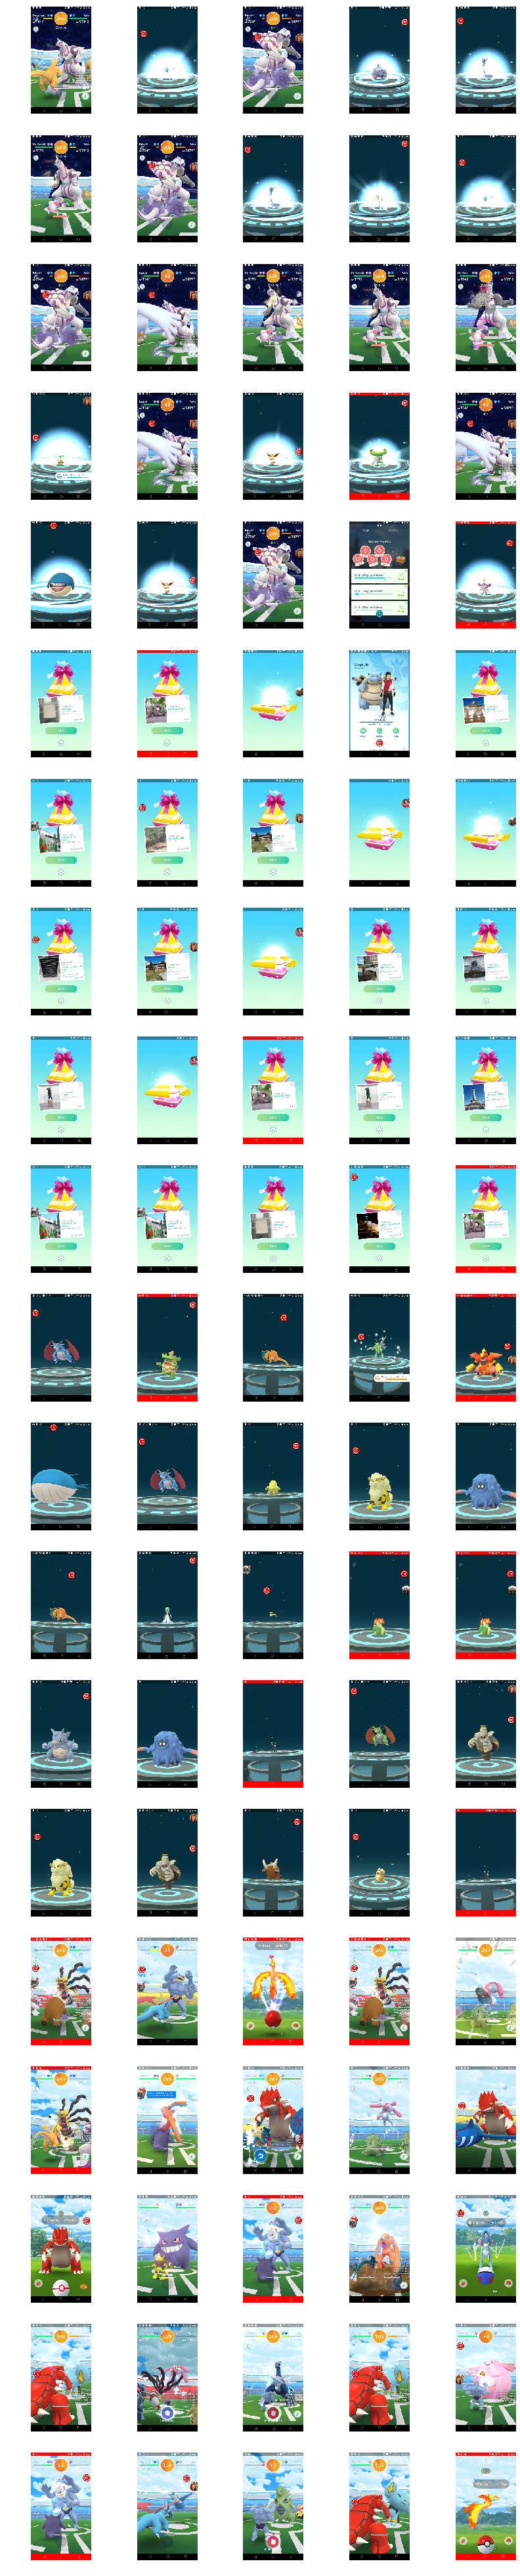

Done !
Wall time: 33.3 s


In [32]:
%%time
# we'll do it with 20 clusters.
k = 20

# kmeans will be our algorithm
k_means = cluster.KMeans(n_clusters=k)
k_means.fit(X)
y = k_means.labels_

# we can plot some images by class to see if it globally worked
path_fullsize = r'D:\Images\pokemon_go'
filenames_fullsize = os.listdir(path_fullsize)
plt.figure(figsize=(14,k*18))
#for i in range(k):
# I only plot results for the first 4 clusters 
# to reduce the size of this notebook
for i in range(4):
    j=0
    while j<25:
        ind = rd.randint(0,n-1)
        if y[ind]==i:
            plt.subplot(k*5,5,1+i*25+j)
            filename = filenames_fullsize[ind]
            img = imread(join(path_fullsize,filename))
            img = resize(
                img, 
                (256,144), 
                mode='constant',
                anti_aliasing=False,
            )
            plt.imshow(img)
            plt.ylabel(str(i))
            plt.axis('off')
            j+=1
plt.show()
done()

As you can see, the result really is satisfying. Some clusters are very homogeneous.

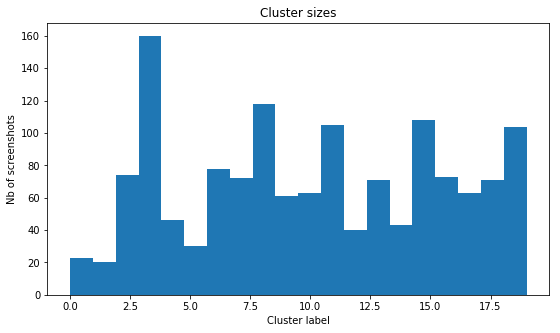

In [33]:
# for our information, here are the cluster size.
plt.figure(figsize=(9,5))
plt.hist(y,bins=k)
plt.title("Cluster sizes")
plt.xlabel("Cluster label")
plt.ylabel("Nb of screenshots")
plt.show()

In order to really see how the clustering looks like, I create a new folder for each cluster and copy-paste full size images to see how it looks.

In [34]:
for i in range(20):
    if not os.path.isdir(join(r'D:\Images\pokemon_go_sorted',str(i))):
        os.mkdir(join(r'D:\Images\pokemon_go_sorted',str(i)))

In [35]:
%%time
for ind in range(n):
    filename = filenames_fullsize[ind]
    src = join(path_fullsize,filename)
    dst = join(r'D:\Images\pokemon_go_sorted',str(y[ind]))
    copy(src,dst)
done()

Done !
Wall time: 1min 11s


To be honest, I was surprised to see how efficient the clustering using only pixels as features. This can be explained by the fact screenshots of the same game on the same smartphone are very similar. You will find exactly the same colors and the same patterns at the exact same position on many images.

## 2. Supervised learning

Now this first approximate clustering is done, it's quite easy to labelize images by hand by simply renaming folder and re-arranging some images. Then, we'll have good data for further learning and building a tool for future images.

After an hour of manual work, here are the new classes. Now I have a labeled database :

In [37]:
path = r'D:\Images\pokemon_go_labeled'

classes = os.listdir(path)
print("There are {} classes.".format(len(classes)))

classes_dict = {}
for i,a in enumerate(classes):
    classes_dict[i]=a

classe_sizes = np.array([len(os.listdir(join(path,c))) for c in classes])

There are 25 classes.


I resize my images once for all.

In [38]:
%%time
# Resize image once for all
X = []
y = []
REZ = 64
for class_index, c in enumerate(classes):
    if not os.path.isdir(join(path+'_64',c)) : os.mkdir(join(path+'_64',c))
    for filename in os.listdir(join(path,c)):
        if os.path.isfile(join(path+'_64',c,filename)): continue
        img = imread(join(path,c,filename))
        img = resize(img, 
                     (REZ,REZ), 
                     mode='constant', 
                     anti_aliasing=False,
                )
        imsave(join(path+'_64',c,filename),img)
done()

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Done !
Wall time: 23.5 s


Load images in a variable. I can do this because the resized images are very small.

In [65]:
X = []
y = []
filenames = []
REZ = 64
path = r'D:\Images\pokemon_go_labeled'+'_'+str(REZ)
for class_index, c in enumerate(classes):
    for filename in os.listdir(join(path,c)):
        filenames.append(join(path,c,filename))
        img =  imread(join(path,c,filename))
        X.append(img)
        y.append(class_index)

Split in train and test.

In [66]:
x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(
    np.array(X), 
    np.array(y), 
    np.arange(len(X)), 
    test_size=0.25,
    random_state=0,
)

x_train = x_train.reshape(-1,REZ*REZ*3)/255
x_test = x_test.reshape(-1,REZ*REZ*3)/255

Label repartition of training and validation images.

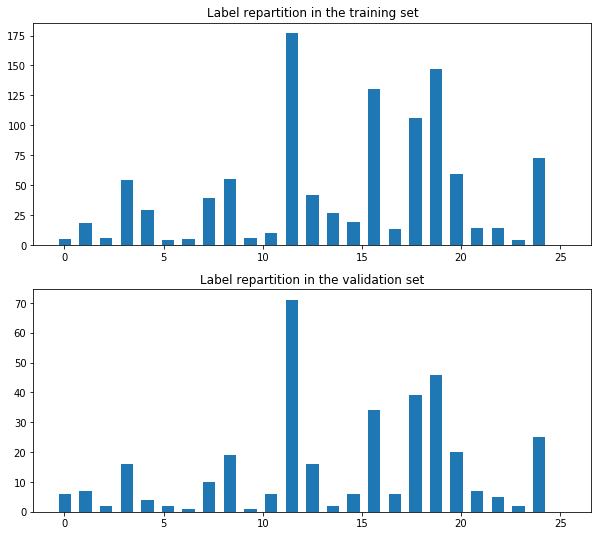

In [67]:
plt.figure(figsize=(10,9))
plt.subplot(211)
plt.hist(
    y_train,
    bins=len(classes),
    rwidth=0.6, 
    range=(-0.5,len(classes)+0.5),
    align='mid',
)
plt.title("Label repartition in the training set")
plt.subplot(212)
plt.hist(
    y_test,
    bins=len(classes),
    rwidth=0.6, 
    range=(-0.5,len(classes)+0.5),
    align='mid',
)
plt.title("Label repartition in the validation set")
plt.show()

Does a RandomForest work ?

In [68]:
%%time
rf = ExtraTreesClassifier(n_estimators=300) #RandomForestClassifier(n_estimators=300)
rf.fit(x_train,y_train)
print(rf.score(x_test,y_test))

0.9745042492917847
Wall time: 6.4 s


Oh damn.. it really works well.

Let's do some hyperparameters tuning.

In [69]:
%%time
param_grid = {
    'n_estimators': [100,200],
#     'max_features': [5,10,20,50,100],
#     'max_depth': [10,20,40,80],
#     'min_samples_leaf' : [1, 2, 4],
}
clf = GridSearchCV(
    cv=5,
    estimator=ExtraTreesClassifier(),
    param_grid=param_grid,
    n_jobs=-1
)
clf.fit(x_train,y_train)

print("Best training score reached : {}".format(clf.best_score_))

print("Best parameters found :",clf.best_params_)
rf = clf.best_estimator_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best training score reached : 0.9583333333333334
Best parameters found : {'n_estimators': 100}
Wall time: 21 s


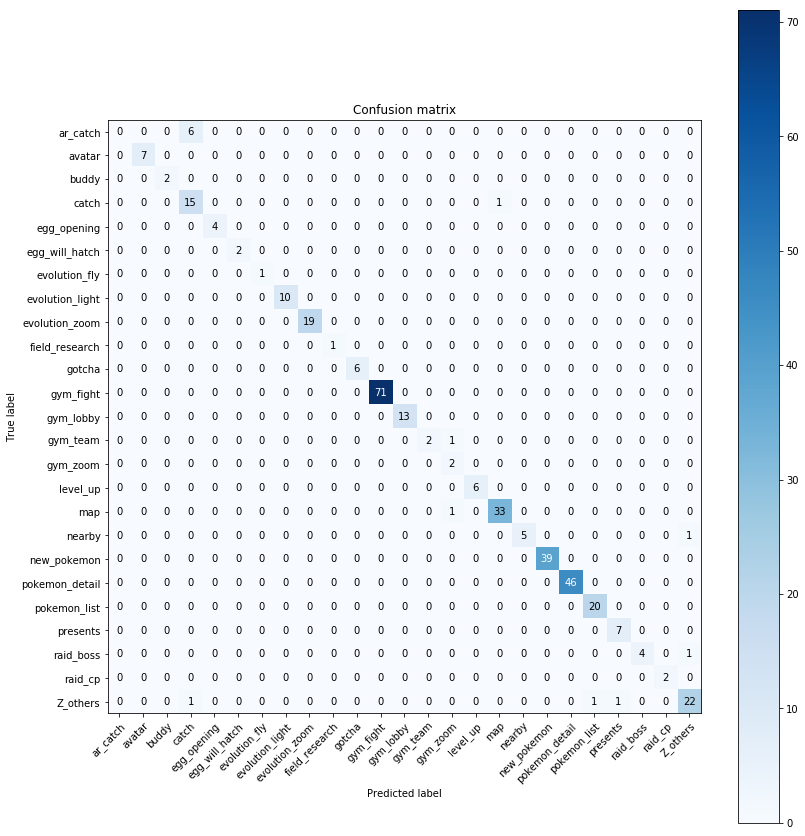

In [70]:
y_true = y_test
y_pred = rf.predict(x_test)

def plot_confusion_matrix(y_true=y_true, 
                          y_pred=y_pred, 
                          classes=classes,
                          normalize=False,
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix()
plt.show()

We got a slightly better forest thanks to hyperparameters tuning. We see on the confusion matrix that the misclassified images are rare.

Let's check the remaining errors of the test set.

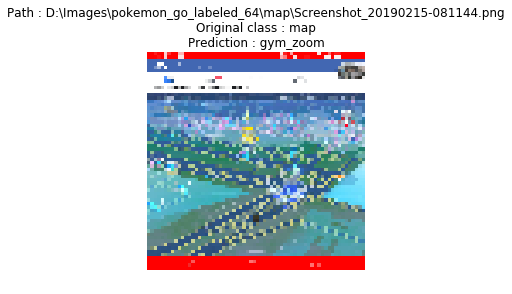

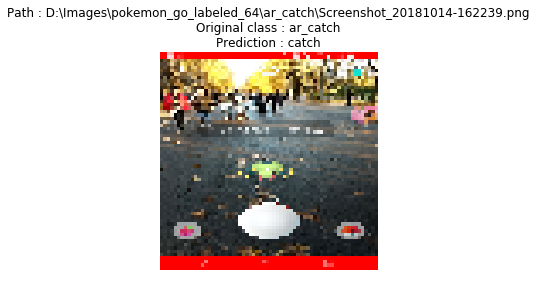

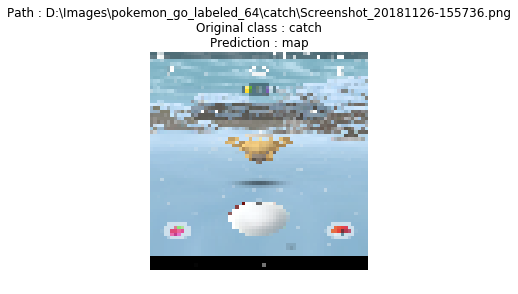

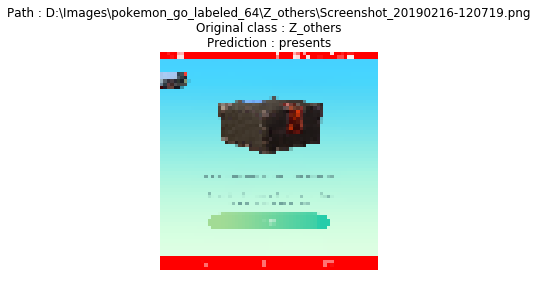

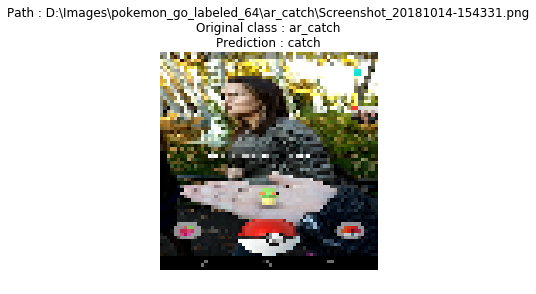

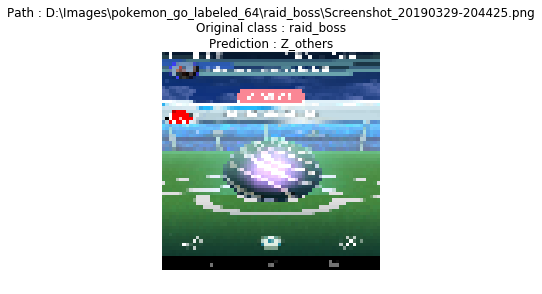

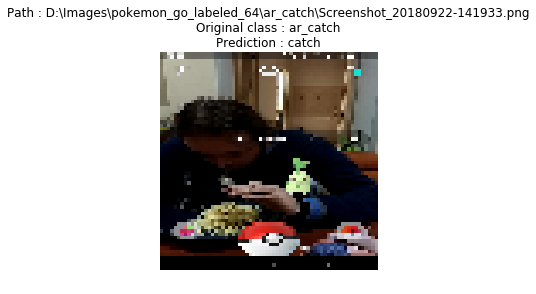

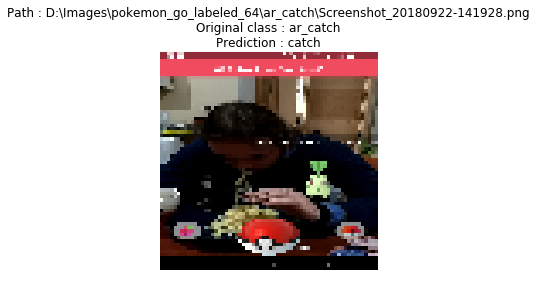

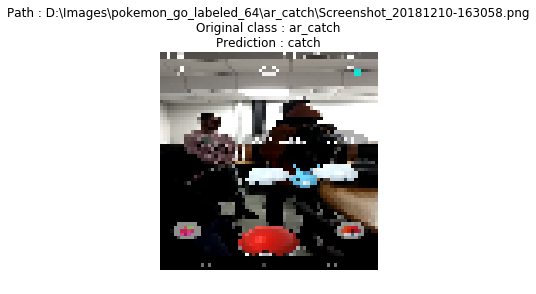

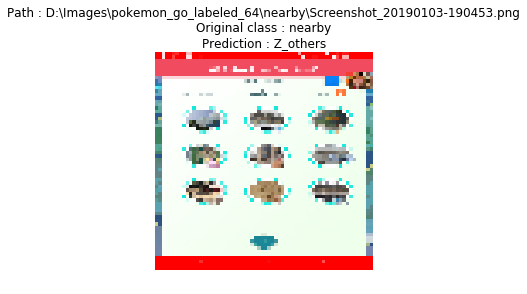

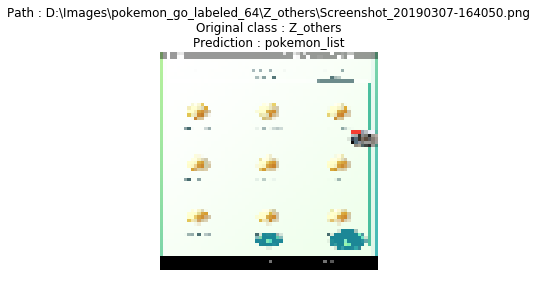

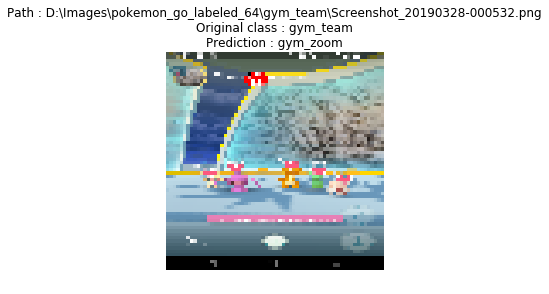

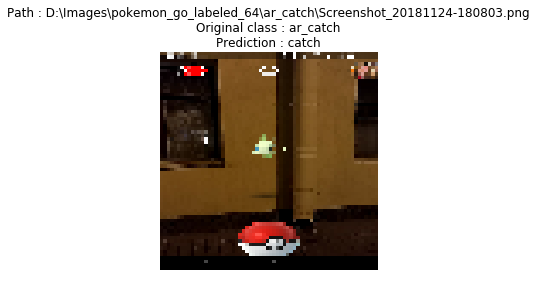

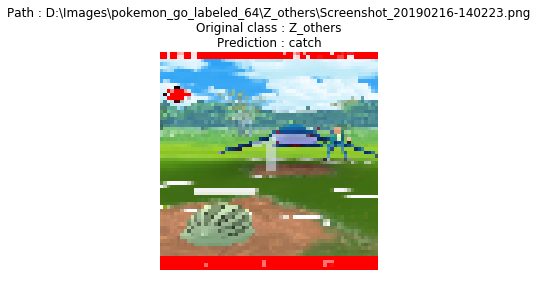

In [71]:
index_val_fails = np.arange(len(y_true))[y_true != y_pred]
index_fails = indices_test[index_val_fails]
for i, img_path in enumerate(np.array(filenames)[index_fails]):
    title = 'Path : {}\nOriginal class : {}\nPrediction : {}'.format(
        img_path,
        classes[y_true[index_val_fails][i]],
        classes[y_pred[index_val_fails][i]],
    )
    plt.title(title)
    img = imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

These errors are interesting and not very surprising. Let's give some analysis that explains why it's hard to sometimes chose between 2 classes :
* gym\_zoom and gym\_team are both screenshots of pokemons placed on a gym, it's zoomed when we focus on a single one and wide when we see the whole team. But if there is a team of small pokemon, the scene is a bit zoomed and if the single pokemon is very big the zoom is still wide. We can excuse the algorithm for this.
* ar\_catch isn't an homogeneous class because the background always change a lot.
* in "catch" we have different bioms, and it's for instance rare to have snowy catch (I don't play much when it's snowing, sorry for that). So a snowy catch is easily misclassified.
* Z\_others is a kind of bin class, highly heterogeneous, it's hard for the algorithm that a scene corresponds to ... nothing !
* I have an app on my phone that artificially decrease lightness for all apps. The pixels values are different when I have this app turned on, so an image is likely to be misclassified if it's darker than usual.

All of this explains our 5% error, and it shows that the remaining 95% is a kind of 100% on very clean data, which is great news.

# What's the point ?

First, it was fun to see if the whole thing could work. It seemed to me it was an easy task, and I had fun data I wanted to play with. Here our predicting tool we can use with an input folder of new images and an ouput folder with classified images.

In [10]:
%%time
INPUT_PATH = r'D:\Images\pokemon_test_in'
OUTPUT_PATH = r'D:\Images\pokemon_test_out'
if not os.path.isdir(OUTPUT_PATH) : os.mkdir(OUTPUT_PATH)

for img_filename in os.listdir(INPUT_PATH):
    img_path = join(INPUT_PATH, img_filename)
    img = imread(img_path)/255
    img = resize(img, (REZ,REZ), mode='constant', anti_aliasing=False)
    img = img.reshape((REZ*REZ*3))
    y = rf.predict([img])[0]
    this_class = classes[y]
    class_path = join(OUTPUT_PATH, this_class)
    if not os.path.isdir(class_path) : 
        os.mkdir(class_path)
    copy(src=img_path, 
         dst=join(class_path, img_filename))

Wall time: 58.9 s


However that's a bit frustrating if the output of all this notebook is a random forest ...

Now that I have well classified data, I can edit a video grouping images by class and have a kind of aftermovie of my one-year pokemon go trip ! Seems to be a nice souvenir ! Here is the code for editing it :

In [72]:
%%time
# video name
video_name = 'pogoall.avi'
# video shape
path = r'D:\Images\pokemon_go_labeled'
folders = [a for a in os.listdir(path) if (os.path.isdir(join(path,a)) and a not in ['ar_catch','Z_others'])]
image_folder = join(path,folders[0])
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape 
# video writer
video = cv2.VideoWriter(join(r'D:\Images\pokemon_go_sorted',video_name), 
                        cv2.VideoWriter_fourcc(*'DIVX'), 
                        3, 
                        (width,height))

# writing
for folder in tqdm(folders):
    image_folder = join(path,folder)
    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

# releasing
cv2.destroyAllWindows()
video.release()
done()

100%|██████████████████████████████████████████| 23/23 [05:46<00:00,  8.38s/it]


Done !
Wall time: 6min 1s
